# 07 Raster2 demo: Reprojection, Clipping, Sampling, Zonal Stats
#### Featuring the best<sup>*</sup> raster of all: DEMs

UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean  

<sup>*</sup>An objective conclusion

## Objectives
* Demonstrate multiple approaches for "on-the-fly" raster data download
* Understand additional fundamental raster processing/analysis:
    * Reprojection
    * Clipping
    * Interpolation and sampling strategies
* Combine vector points and polygons with rasters for zonal statistics
* Understand processing strategies, derivative products, and common applications for a fundamental raster data product: DEMs
    * Slope and Aspect
    * Contour generation
    * Volume estimation (cut/fill analysis)

## What is a DEM?
DEM = Digital Elevation Model

A generic term for a 2D raster grid with values representing surface elevation above some datum (e.g., WGS84 ellispoid or a geoid model representing mean sea level).  Sometimes called 2.5D, as it's not a true 3D dataset containing some value (e.g., temperature) at each (x,y,z) point.

There are subtypes:
* DSM = Digital Surface Model ("first-return" model includes top of canopy, buildings, etc.)
* DTM = Digital Terrain Model (bare ground model, with canopy, buildings, etc. removed)

Great resource on LiDAR and derivative products: 
* https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/
* https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-chm-dem-dsm/

### Airborne LiDAR example
* https://www.dnr.wa.gov/lidar
* https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=b93c17aa1ef24669b656dbaea009b5ce
* https://wadnr.maps.arcgis.com/apps/Cascade/index.html?appid=36b4887370d141fcbb35392f996c82d9
* https://lidarportal.dnr.wa.gov/

### SRTM
SRTM = Shuttle Radar Topography Mission  
* https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission
* https://www2.jpl.nasa.gov/srtm/

This week, we'll play with the landmark SRTM dataset.  We briefly introduced this during Lab03, as I sampled the SRTM products for the GLAS point locations and included as the `dem_z` column in the csv.
* Collected February 11-22, 2000 (winter)
* Single-track InSAR (interferometric synthetic aperture radar) instrument
* Coverage: 56°S to 60°N (the shuttle orbit, plus radar look direction)
* Tiled in 1x1° raster data at different resolutions: 
    * 1-arcsecond (~30 m)
    * 3-arcsecond (~90 m)
* Default elevation values in the SRTM tiles are relative to the EGM96 geoid (approximates mean sea level), not the WGS84 ellipsoid (as with the GLAS points)

For this lab, we'll use the 3-arcsec (90 m) SRTM product for WA state to learn some new concepts.  This is a relatively small dataset, with a limited number of 1x1° tiles required for WA state.  However, the approaches we'll learn (e.g., API subsetting, using vrt datasets), scale to larger datasets that are too big to fit in memory (like operations on the global SRTM dataset).  In future weeks, we'll explore xarray, which can also be used to efficiently process raster data (and raster time series).

### Copernicus DEM
* https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198
* https://spacedata.copernicus.eu/documents/20126/0/GEO1988-CopernicusDEM-SPE-002_ProductHandbook_I1.00.pdf
* https://spacedata.copernicus.eu/documents/20126/0/GEO1988-CopernicusDEM-RP-001_ValidationReport_V1.0.pdf

## Interactive discussion topics
* Mixing command line utilities and Python API code
* Raster reprojection
    * https://support.esri.com/en/technical-article/000008915
    * https://en.wikipedia.org/wiki/Bilinear_interpolation
    * https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-r
    * Separate from visualization - another round of interpolation!
        * https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/interpolation_methods.html
* Raster interpolation from unstructured points (e.g. Lidar point clouds)
    * https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/what-is-lidar-data/lidar-points-to-pixels-raster/
* Combining raster and vector
    * sampling at points
    * zonal statistics for polygons
        * https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
* Volume calculations
* DEM derivative products: shaded relief, slope, aspect
* Raster/array filtering
    * Moving window operations
    * https://docs.scipy.org/doc/scipy/reference/ndimage.html
* vrt

In [4]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
import rioxarray

In [5]:
from matplotlib_scalebar.scalebar import ScaleBar

In [6]:
%matplotlib inline

## Download sample SRTM data for WA state

### Define the Washington state bounds from previous notebook
* Use the lat/lon bounds here in decimal degrees

In [7]:
wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)

### Use OpenTopography GlobalDEM API to fetch DEM for WA state
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* We'll use this service to extract a small portion of the SRTM-GL3 DEM

In [8]:
#List of all products hosted by OpenTopography GlobalDEM API
demtype_list = ['SRTMGL3', 'SRTMGL1', 'SRTMGL1_E', 'AW3D30', 'AW3D30_E', 'SRTM15Plus',\
                'NASADEM', 'COP30', 'COP90']

In [9]:
demtype = demtype_list[-1]

In [10]:
base_url="https://portal.opentopography.org/API/globaldem?demtype={}&API_Key={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [11]:
#We are using demo API key here - only valid for 25 requests from a single IP address
#please save local output and use moving forward
API_key="demoapikeyot2022"

In [9]:
base_url.format(demtype, API_key, *wa_bounds)

'https://portal.opentopography.org/API/globaldem?demtype=COP90&API_Key=demoapikeyot2022&west=-124.733174&south=45.543541&east=-116.915989&north=49.002494&outputFormat=GTiff'

In [10]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, API_key, *wa_bounds)
        print(url)
        #Get
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)

In [11]:
#Output filename
out_fn = f"WA_{demtype}.tif"
out_fn

'WA_COP90.tif'

In [12]:
get_OT_GlobalDEM(demtype, wa_bounds, out_fn)

In [13]:
!ls -lah $out_fn

-rw-rw-r-- 1 jovyan users 142M Feb 16 21:49 WA_COP90.tif


In [14]:
!gdalinfo $out_fn

Warning 1: WA_COP90.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Driver: GTiff/GeoTIFF
Files: WA_COP90.tif
Size is 9381, 4151
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-124.733333333333320,49.002916666666664)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-12

### Open the file with rasterio

In [15]:
src = rio.open(out_fn)

### Review the metadata
* Note the input data type - are these values unsigned or signed (meaning values can be positive or negative)?

In [16]:
src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9381, 'height': 4151, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0008333333333333334, 0.0, -124.73333333333332,
       0.0, -0.0008333333333333334, 49.002916666666664), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

### Plot using `rio.plot.show()`
* Use the `with` construct here to cleanly open and close the `vrt` file, with better handling of any exceptions

In [17]:
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
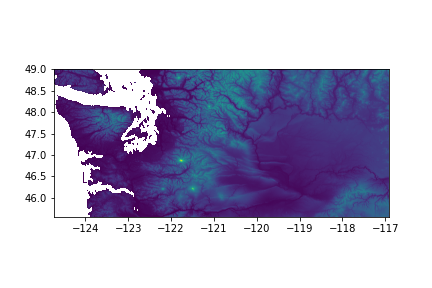

In [18]:
with rio.open(out_fn) as src:
    rio.plot.show(src)

Nice!  WA state really does have interesting topography.  Much more interesting than Kansas:
* https://www.usu.edu/geo/geomorph/kansas.html

### Read the data and plot with matplotlib
* Read the data to a NumPy array
    * Note that the tiles on disk are not actually loaded until you `read` the dataset
    * Make sure you deal with nodata, either with a NumPy masked array, or setting nodata to np.nan (remember np.nan is a float, your input data type is int16)
* View with matplotlib imshow - verify you have a DEM of washington state

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
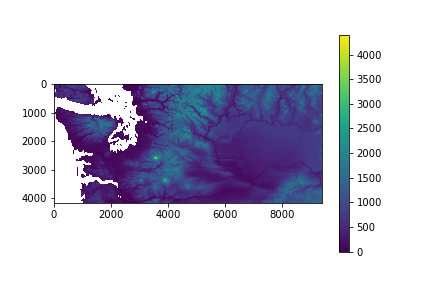

In [19]:
with rio.open(out_fn, 'r+') as src:
    f, ax = plt.subplots()
    src.nodata = 0.0
    dem = src.read(1, masked=True)
    m = ax.imshow(dem)
    plt.colorbar(m)

## Raster reprojection using GDAL and rasterio

#### Reproject the SRTM vrt to UTM 10N
* The SRTM grids are distributed with crs of EPSG:4326
* Let's reproject to a more appropriate coordinate system for WA state
    * Use EPSG:32610

In [20]:
dst_crs = 'EPSG:32610'

### First, reproject using `gdalwarp` command-line utility
* A very simple, efficient way to accomplish this - let GDAL worry about all of the underlying math
* Review the documentation and options here: https://gdal.org/programs/gdalwarp.html
    * Resampling options: https://gdal.org/programs/gdalwarp.html#cmdoption-gdalwarp-r 
* Save the projected file as a GeoTiff on disk
    * Use `cubic` resampling algorithm
* Note the filesize using `ls -lh`

In [21]:
proj_fn = os.path.splitext(out_fn)[0]+'_utm_gdalwarp.tif'

In [22]:
%%time
if not os.path.exists(proj_fn):
    !gdalwarp -r cubic -t_srs $dst_crs $out_fn $proj_fn

Warning 1: WA_COP90.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Creating output file that is 8877P x 5851L.
Processing WA_COP90.tif [1/1] : 0Using internal nodata values (e.g. 0) for image WA_COP90.tif.
Copying nodata values from source WA_COP90.tif to destination WA_COP90_utm_gdalwarp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 253 ms, sys: 96.3 ms, total: 350 ms
Wall time: 15.1 s


In [23]:
ls -lh $proj_fn

-rw-r--r-- 1 jovyan users 199M Feb 16 23:20 WA_COP90_utm_gdalwarp.tif


In [24]:
!gdalinfo $proj_fn

Driver: GTiff/GeoTIFF
Files: WA_COP90_utm_gdalwarp.tif
Size is 8877, 5851
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],


### A note about "creation options" when writing a new file to disk
* Review this great reference on GeoTiff file format: https://www.gdal.org/frmt_gtiff.html
    * See Creation Options section toward bottom of page: https://gdal.org/drivers/raster/gtiff.html#creation-options
* I almost always use `-co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER`
    * Uses lossless LZW compression (we explored in LS8 example comparing filesize on disk to your calculated array filesize)
    * Writes the tif image in "tiles" of 256x256 px instead of one large block - makes it much more efficient to read and extract a subwindow from the tif
    * If necessary, use the BIGTIFF format for files that are >4 GB

### Write out the same file, but this time use tiling and LZW compression
* Compare the new filesize on disk

In [25]:
proj_fn_lzw = os.path.splitext(out_fn)[0]+'_utm_gdalwarp_lzw.tif'

In [26]:
%%time
if not os.path.exists(proj_fn_lzw):
    !gdalwarp -r cubic -t_srs $dst_crs -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER $out_fn $proj_fn_lzw

Warning 1: WA_COP90.tif: This file used to have optimizations in its layout, but those have been, at least partly, invalidated by later changes
Creating output file that is 8877P x 5851L.
Processing WA_COP90.tif [1/1] : 0Using internal nodata values (e.g. 0) for image WA_COP90.tif.
Copying nodata values from source WA_COP90.tif to destination WA_COP90_utm_gdalwarp_lzw.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
CPU times: user 296 ms, sys: 78.6 ms, total: 374 ms
Wall time: 17.6 s


In [27]:
ls -lh $proj_fn_lzw

-rw-r--r-- 1 jovyan users 176M Feb 16 23:20 WA_COP90_utm_gdalwarp_lzw.tif


In [28]:
#Let's use the compressed file from here on out
#Should compare runtimes when using compressed vs. uncompressed
proj_fn = proj_fn_lzw

### Load your reprojected dataset and plot

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
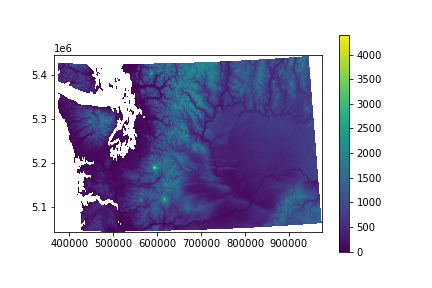

In [29]:
with rio.open(proj_fn) as src_proj:
    rio.plot.show(src_proj)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
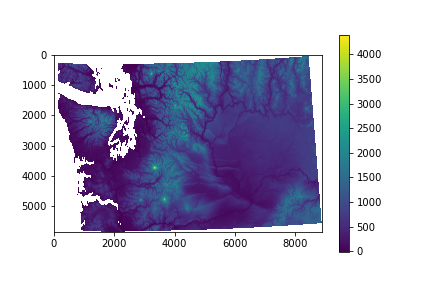

In [30]:
with rio.open(proj_fn, 'r+') as src:
    f, ax = plt.subplots()
    src.nodata = 0.0
    dem = src.read(1, masked=True)
    m = ax.imshow(dem)
    plt.colorbar(m)

## Reprojection using rasterio API
* This is still surprisingly complicated compared to the GeoPandas `to_crs` method
    * But if you look at what's actually happening, it's not too bad
* See example here: https://rasterio.readthedocs.io/en/stable/topics/reproject.html#reprojecting-a-geotiff-dataset
* Define your coordinate system as `dst_crs` variable (needed later)
* Save the projected file as a GeoTiff on disk
    * print the metadata of your input and output datasets
    * If you are copying the metadata from your input dataset (as in the rasterio doc example), you will need to update the 'driver' to 'GTiff' before open the file for writing
    * Use cubic resampling algorithm
* You can specify these configuration options in the `rasterio.open()` kwargs:
    * https://github.com/mapbox/rasterio/blob/master/docs/topics/image_options.rst
    * https://rasterio.readthedocs.io/en/stable/topics/profiles.html
    * https://rasterio.readthedocs.io/en/stable/topics/configuration.html
* Note that it is also possible to reproject and store the resulting dataset in memory, rather than writing to disk
    * This is desirable if you need to temporarily reproject a raster dataset, read the array, do some analysis

In [31]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [32]:
src = rio.open(out_fn)
proj_fn = os.path.splitext(out_fn)[0]+'_utm_riowarp.tif'
rio_reproj_write(src, proj_fn, dst_crs)

File exists:  WA_COP90_utm_riowarp.tif


In [33]:
%pwd

'/home/jovyan/jupyterbook/book/modules/07_Raster2_DEMs_Warp_Clip_Sample'

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
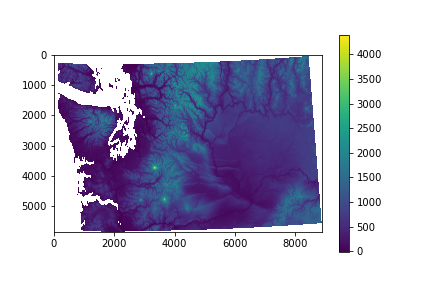

In [34]:
with rio.open(proj_fn, 'r+') as src:
    f, ax = plt.subplots()
    src.nodata = 0.0
    dem = src.read(1, masked=True)
    m = ax.imshow(dem)
    plt.colorbar(m)

In [35]:
src_proj = rio.open(proj_fn)

In [36]:
src_proj.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 8877, 'height': 5851, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(68.74847128155481, 0.0, 364685.4908997369,
       0.0, -68.74847128155481, 5445638.415841511), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [37]:
#Load as a masked array
srtm_proj = src_proj.read(1, masked=True)

In [38]:
srtm_proj.shape

(5851, 8877)

## Discussion Questions
* What is the projected x and y cell size (output resolution)?
* Is this consistent with your expectation for the 3-arcsec SRTM data?
    * Hint: Think about the dimensions of a pixel in meters near the top and bottom of the input SRTM grid. Then think back to Lab04 when we calculated length of a degree of longitude and a degree of latitude at different locations on the planet.
    * Info on an arcsecond: https://www.esri.com/news/arcuser/0400/wdside.html
* Note that if the output resolution is unspecified, GDAL and rasterio will estimate for you.  But you can also specify this output resolution (`-tr` argument in `gdalwarp`), if, for example, you wanted to resample your output to 180 m resolution.

In [39]:
src_proj.transform

Affine(68.74847128155481, 0.0, 364685.4908997369,
       0.0, -68.74847128155481, 5445638.415841511)

In [40]:
src_proj.res

(68.74847128155481, 68.74847128155481)

## Create a shaded relief map (hillshade) from your projected DEM
* See background info on hillshades (and other DEM derivative products like slope and aspect) here: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-hillshade-works.htm
* Can do this easily with `gdaldem` command line utility: https://www.gdal.org/gdaldem.html
    * Try this and output to a new file
    * Note that if you were to run on a DEM with different horizontal and vertical units, (like say, degrees and meters), you will have scaling issues. There are ways around this, but Always generate hillshade using a projected DEM.

In [41]:
hs_fn = os.path.splitext(proj_fn)[0]+'_hs.tif'

In [42]:
if not os.path.exists(hs_fn):
    !gdaldem hillshade $proj_fn $hs_fn

* Can also use GDAL Python API directly
    * Documentation of this functionality is poor, but it's pretty simple (see my example below)
    * Some examples are here: https://github.com/OSGeo/gdal/blob/master/autotest/utilities/test_gdaldem_lib.py

### Example using GDAL API

In [43]:
def gdal_hs_ds(fn):
    from osgeo import gdal
    #Open the GDAL dataset
    dem_ds = gdal.Open(fn)
    #Specify the type of product we want (e.g., hillshade, slope, aspect) - see gdaldem doc for list of avaiable options
    producttype = 'hillshade'
    #Create a GDAL hillshade dataset in memory
    hs_ds = gdal.DEMProcessing('', dem_ds, 'hillshade', format='MEM')
    return hs_ds

def gdal_hs_ma(fn):
    #Get GDAL Dataset
    hs_ds = gdal_hs_ds(fn)
    #Read the dataset as a NumPy array
    hs = hs_ds.ReadAsArray()
    return hs

In [44]:
#Create hillshade from a filename
#hs_ma = gdal_hs_ma(fn)
#plt.imshow(hs_ma, cmap='gray')

### Work in progress: dynamically create shaded relief, slope and aspect using numpy

In [45]:
#Function to return hillshade (for visualization), slope magnitude (deg) and aspect on the fly
#This is a work in progress, aspect values are incorrect!
def hillshade(a, res=1.0, sun_az=315, sun_el=45):
    sun_az = 360.0 - sun_az
    dx, dy = np.gradient(a, res)
    slope = np.pi/2. - np.arctan(np.sqrt(dx*dx + dy*dy))
    aspect = np.arctan2(-dx, dy)
    shaded = np.sin(np.radians(sun_az)) * np.sin(slope) + \
    np.cos(np.radians(sun_el)) * np.cos(slope) * \
    np.cos((np.radians(sun_az) - np.pi/2.) - aspect)
    hs = 255 * (shaded + 1)/2
    return hs, np.degrees(np.pi/2. - slope), np.degrees(aspect)

## Load your shaded relief map as a new NumPy masked array 
* Note that the datatype is 8-bit (Byte), with values from 0-255 (it's a grayscale image, not elevation data)
* Make sure you mask nodata values

In [46]:
hs_src = rio.open(hs_fn)
hs = hs_src.read(1, masked=True)

## Get the extent of the hillshade dataset in the projected coordinate system
* See `rio.plot.plotting_extent`
* Pass this to imshow `extent` and verify that your coordinates look good

In [47]:
hs_extent = rio.plot.plotting_extent(hs_src)
hs_extent

(364685.4908997369, 974965.6704660989, 5043391.110373134, 5445638.415841511)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
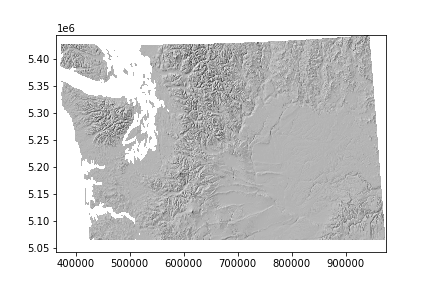

In [48]:
f, ax = plt.subplots()
ax.imshow(hs, cmap='gray', extent=hs_extent);

# Part 2: Clipping Raster data

## Load the states GeoDataFrame

In [49]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.60650, -70.82373 ..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11579, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.05770 44.99743, -104.25015 44.9..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.05060 37.00040, -114.04999 36.9..."


## Reproject the GeoDataFrame to match your DEM

In [50]:
states_gdf_proj = states_gdf.to_crs(dst_crs)

## Isolate the WA state geometry object
* We want the geometry, not a GeoDataFrame or GeoSeries

In [51]:
wa_state = states_gdf_proj.loc[states_gdf_proj['NAME'] == 'Washington']
wa_geom = wa_state.iloc[0].geometry

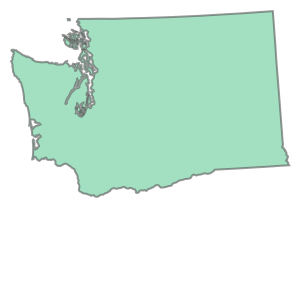

In [52]:
wa_geom

## Clip your projected DEM dataset (not the hillshade) to the WA state multipolygon
* This is a common GIS operation
* Some useful resources:
    * https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html
    * https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
    * https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/crop-raster-data-with-shapefile-in-python/
* Note that input for rasterio `mask` is a rasterio dataset, not a numpy array
* Can experiment with different options (which are a bit different than other rasterio syntax):
    * These will return a masked array (and transform) ready for analysis: `filled=False, crop=True, indexes=1`
* Plot with `imshow` to verify - you should see a DEM clipped to WA state outline!
    * Use `rio.plot.plotting_extent` to get the projected coordinate extent, and pass this to the imshow `extent`
        * https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.plotting_extent

In [53]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}

In [54]:
wa_ma, wa_ma_transform = rio.mask.mask(src_proj, wa_geom, **rio_mask_kwargs)

/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
/srv/conda/envs/notebook/lib/python3.9/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


In [55]:
wa_ma.shape

(5834, 8728)

In [56]:
wa_ma_transform

Affine(68.74847128155481, 0.0, 371079.0987289215,
       0.0, -68.74847128155481, 5444607.188772288)

In [57]:
#Get clipped extent in UTM coordaintes
wa_ma_extent = rio.plot.plotting_extent(wa_ma, wa_ma_transform)
wa_ma_extent

(371079.0987289215, 971115.7560743319, 5043528.607315698, 5444607.188772288)

In [58]:
#Original unclipped extent for comparison
src_proj.bounds

BoundingBox(left=364685.4908997369, bottom=5043391.110373134, right=974965.6704660989, top=5445638.415841511)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
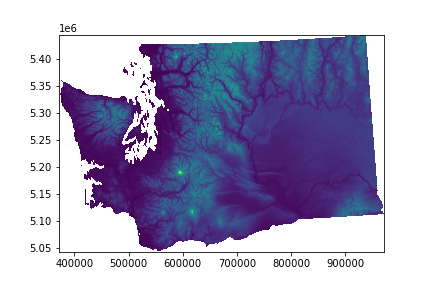

In [59]:
f, ax = plt.subplots()
ax.imshow(wa_ma, extent=wa_ma_extent);

## Comparing rasters
* Let's use rioxarray here
* https://corteva.github.io/rioxarray/stable/index.html
* https://corteva.github.io/rioxarray/stable/examples/reproject_match.html

In [12]:
cop90_fn = 'WA_COP90_utm_riowarp.tif'

In [13]:
cop90_xds = rioxarray.open_rasterio(cop90_fn)

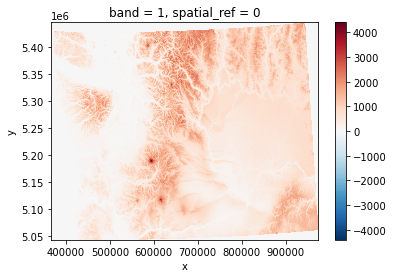

In [24]:
cop90_xds.plot()

In [14]:
srtm_fn = 'WA_SRTMGL3.tif'

In [15]:
srtm_xds = rioxarray.open_rasterio(srtm_fn)

In [16]:
srtm_xds

<xarray.DataArray (band: 1, y: 4151, x: 9381)>
[38940531 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -124.7 -124.7 -124.7 ... -116.9 -116.9 -116.9
  * y            (y) float64 49.0 49.0 49.0 49.0 ... 45.55 45.55 45.55 45.54
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

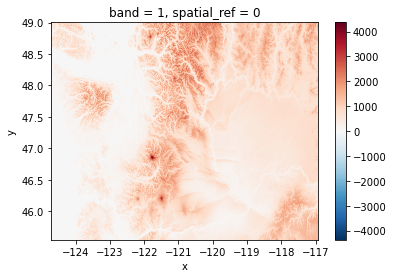

In [17]:
srtm_xds.plot()

In [18]:
srtm_xds_match = srtm_xds.rio.reproject_match(cop90_xds)

In [19]:
srtm_xds_match

<xarray.DataArray (band: 1, y: 5851, x: 8877)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int16)
Coordinates:
  * x            (x) float64 3.647e+05 3.648e+05 ... 9.749e+05 9.749e+05
  * y            (y) float64 5.446e+06 5.446e+06 ... 5.043e+06 5.043e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    0

In [20]:
srtm_xds_match.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 10N",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    prime_meridian_name:               Greenwich
    geographic_crs_name:               WGS 84
    horizontal_datum_name:             World Geodetic System 1984
    projected_crs_name:                WGS 84 / UTM zone 10N
    grid_mapping_name:                 transverse_mercator
    latitude_of_projection_origin:     0.0
    longitude_of_central_meridian:     -123.0
    false_easting:                     500000.0
    false_northing:                    0.0
    scale_factor_at_central_meridian:  0.9996
    spatial_ref:                       PROJCS["WGS 84 / UTM zone 10N",GEOGCS[...
    GeoTransform:                      364685.4908997369 68.7484712815548 0.0...

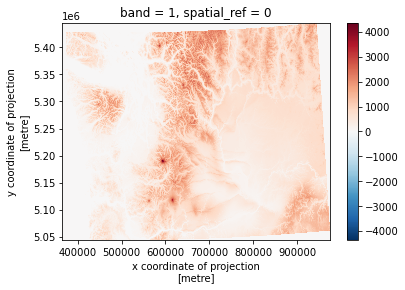

In [21]:
srtm_xds_match.plot()

In [22]:
diff = cop90_xds - srtm_xds_match

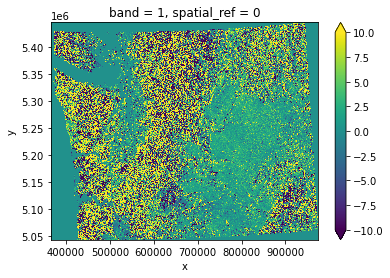

In [25]:
diff.plot(vmin=-10, vmax=10)

In [26]:
diff_fn = 'WA_COP90_SRTMGL3_diff.tif'

In [28]:
diff.rio.to_raster(diff_fn)

In [29]:
!gdalinfo $diff_fn

Driver: GTiff/GeoTIFF
Files: WA_COP90_SRTMGL3_diff.tif
Size is 4759, 4546
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 10N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 10N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-123,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
